## Installing Dependencies

In [ ]:


%pip install ta darts xgboost

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ------ --------------------------------- 12.6/72.0 MB 60.7 MB/s eta 0:00:01
   ------------ --------------------------- 22.0/72.0 MB 63.2 MB/s eta 0:00:01
   ------------- -------------------------- 24.4/72.0 MB 40.6 MB/s eta 0:00:02
   --------------- ------------------------ 28.6/72.0 MB 34.8 MB/s eta 0:00:02
   ------------------- -------------------- 34.6/72.0 MB 35.4 MB/s eta 0:00:02
   ------------------- -------------------- 35.9/72.0 MB 30.0 MB/s eta 0:00:02


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.


In [2]:
%load_ext cudf.pandas

ModuleNotFoundError: No module named 'cudf'

In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*Period with BDay freq.*", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Parameters:.*are not used.*", category=UserWarning)

# Loading Datasets

NOTE: Upload files to the colab before running the below cell

In [ ]:
import pandas as pd

column_map = {'c': 'close', 'h' : 'high', 'l' : 'low', 'o' : 'open', 't' : 'date', 'v' : 'volume'}

df_price = pd.read_json('/content/aapl_price.json')[column_map.keys()].rename(columns=column_map)
df_fundamentals = pd.read_csv('/content/aapl_fundamentals.csv').rename(columns={'Quarter End Date' : 'date'})
df_vix = pd.read_csv('/content/vix.csv').rename(columns={'DATE' : 'date'})

/usr/local/lib/python3.12/dist-packages/cudf/io/json.py:247: UserWarning: Using CPU via Pandas to read JSON dataset, this may be GPU accelerated in the future
  warnings.warn(


In [ ]:
display(df_price.head())
display(df_fundamentals.head())
display(df_vix.head())

,close,high,low,open,date,volume
0,23.78,23.78,23.02,23.16,2016-01-04T05:00:00Z,287741356
1,23.18,23.89,23.11,23.87,2016-01-05T05:00:00Z,234762144
2,22.73,23.10,22.54,22.69,2016-01-06T05:00:00Z,284319308
3,21.77,22.60,21.76,22.27,2016-01-07T05:00:00Z,343985812
4,21.88,22.37,21.84,22.24,2016-01-08T05:00:00Z,300265168


,date,EBITDA (USD millions),EV (USD millions)
0,2025-09-30,"35,550","3,790,000"
1,2025-06-30,"31,032","3,060,000"
2,2025-03-31,"32,250","3,340,000"
3,2024-12-31,"45,912","3,920,000"
4,2024-09-30,"32,502","3,550,000"


,date,OPEN,HIGH,LOW,CLOSE
0,01/02/1990,17.24,17.24,17.24,17.24
1,01/03/1990,18.19,18.19,18.19,18.19
2,01/04/1990,19.22,19.22,19.22,19.22
3,01/05/1990,20.11,20.11,20.11,20.11
4,01/08/1990,20.26,20.26,20.26,20.26


# Data Curation

### DateTime Conversion

In [ ]:
df_price['date'] = pd.to_datetime(df_price['date']).dt.tz_localize(None).dt.normalize()
df_fundamentals['date'] = pd.to_datetime(df_fundamentals['date']).dt.normalize()
df_vix['date'] = pd.to_datetime(df_vix['date']).dt.normalize()

In [ ]:
print(df_price.dtypes)
print(df_fundamentals.dtypes)
print(df_vix.dtypes)

close            float64
high             float64
low              float64
open             float64
date      datetime64[ns]
volume             int64
dtype: object
date                     datetime64[ns]
EBITDA (USD millions)            object
EV (USD millions)                object
dtype: object
date     datetime64[ns]
OPEN            float64
HIGH            float64
LOW             float64
CLOSE           float64
dtype: object


### Numeric Column Conversion

In [ ]:
df_fundamentals = df_fundamentals.replace(to_replace=',', value='', regex=True).astype({'EBITDA (USD millions)' : 'float', 'EV (USD millions)' : 'float'})

### Time Series Index

In [ ]:
df_price = df_price.set_index('date')
df_fundamentals = df_fundamentals.set_index('date')
df_vix = df_vix.set_index('date')

# Feature Engineering

## Normalized Close

In [ ]:
from ta.trend import SMAIndicator

sma = SMAIndicator(df_price['close'], window=20)

df_price['norm_close'] = df_price['close']/sma.sma_indicator()

## MACD

In [ ]:
from ta.trend import MACD

macd = MACD(df_price['close'])

df_price['macd_line'] = macd.macd()
df_price['macd_diff'] = macd.macd_diff()
df_price['macd_signal'] = macd.macd_signal()

## RSI

In [ ]:
from ta.momentum import RSIIndicator

rsi = RSIIndicator(df_price['close'])

df_price['rsi'] = rsi.rsi()

## EV/EBIDTA

In [ ]:
df_fundamentals['ev_ebidta'] = df_fundamentals['EV (USD millions)']/df_fundamentals['EBITDA (USD millions)']

## OBV





In [ ]:
from ta.volume import OnBalanceVolumeIndicator
from ta.trend import SMAIndicator

obv = OnBalanceVolumeIndicator(df_price['close'], df_price['volume'])

obv_series = obv.on_balance_volume()

sma = SMAIndicator(obv_series, window=20)

df_price['norm_obv_diff'] = obv_series.diff() / sma.sma_indicator()

## Normalized VIX Change

In [ ]:
from ta.trend import SMAIndicator

vix_sma = SMAIndicator(df_vix['CLOSE'], window=20)

df_vix['norm_vix_change'] = df_vix['CLOSE'].pct_change(5) * 100 / vix_sma.sma_indicator()

## Closing price 5 Day Returns

In [ ]:
df_price['price_change'] = df_price["close"].shift(-5).pct_change(periods=5) * 100

## Data Set Creation

Combining different data sets into one

In [ ]:
df = pd.concat([df_price[['norm_close', 'price_change', 'macd_line', 'macd_diff', 'macd_signal', 'rsi', 'norm_obv_diff']], df_fundamentals[['ev_ebidta']], df_vix[['norm_vix_change']]], axis=1)

Forward fill the ev_ebidta since its quarterly data

In [ ]:
df['ev_ebidta'] = df['ev_ebidta'].ffill()

filtering nan rows

In [ ]:
df = df.dropna()

aligning columns

In [ ]:
df = df[['norm_close', 'norm_obv_diff', 'macd_line', 'macd_diff', 'macd_signal', 'rsi', 'ev_ebidta', 'norm_vix_change', 'price_change']]
df.head()

,norm_close,norm_obv_diff,macd_line,macd_diff,macd_signal,rsi,ev_ebidta,norm_vix_change,price_change
date,,,,,,,,,
2016-03-31,1.041724,-0.107127,0.559188,0.066089,0.493099,71.008470,38.940719,-0.422218,-0.404367
2016-04-01,1.047156,0.101163,0.584986,0.073510,0.511476,73.167919,38.940719,-0.717148,-1.241987
2016-04-04,1.053577,0.133250,0.618475,0.085599,0.532876,75.319795,38.940719,-0.477911,-1.864340
2016-04-05,1.037534,-0.090122,0.614530,0.065323,0.549207,68.460985,38.940719,0.757635,0.561798
2016-04-06,1.043449,0.085590,0.625177,0.060776,0.564401,71.009868,38.940719,0.259670,0.953137


writing to a csv file

In [ ]:
df.to_csv("/content/aapl_model_dataset.csv", index=True, header=True)

# Model Implementation

## Functions

In [ ]:
def test_train_split(df, target_col, test_size=0.1):
  total_length = df.count().max()
  split_len = int(total_length * test_size)
  split_idx = total_length - split_len
  X, y = df[[x for x in df.columns if x != target_col]], df[[target_col]]
  X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
  y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
  return X_train, X_test, y_train, y_test, split_len

## ARIMA

In [ ]:
target_col = 'price_change'

### Test Train Split

In [ ]:
X_train, X_test, y_train, y_test, split_len = test_train_split(df, target_col, 0.1)

### Training

In [ ]:
import numpy as np
import cudf
from cuml.tsa.arima import ARIMA

arima = ARIMA(y_train[target_col], order=(1,0,1), fit_intercept=False)

arima.fit()

ARIMA()

### Prediction

In [ ]:
y_predict = pd.concat([arima.predict(end=len(y_train)), arima.forecast(split_len)], axis=0)

### Metrics

In [ ]:
from sklearn.metrics import r2_score

metrics = {
    'ARIMA' : {
        'Training_Accuracy': r2_score(y_train[target_col], y_predict.iloc[:len(y_train)]) * 100 ,
        'Testing_Accuracy' : r2_score(y_test[target_col], y_predict.iloc[len(y_train):]) * 100
        }
}

print(f'Training accuracy: {metrics['ARIMA']['Training_Accuracy'] :.3f}%')
print(f'Testing accuracy: {metrics['ARIMA']['Testing_Accuracy'] :.3f}%')

Training accuracy: 61.162%
Testing accuracy: -0.260%


### Feature Egineering

In [ ]:
y_predict = y_predict.reset_index(drop=True)
y_predict.index = df.index
df['arima_pred'] = y_predict
df = df[[*[x for x in df.columns if x != target_col], target_col]]
df.head()

,norm_close,norm_obv_diff,macd_line,macd_diff,macd_signal,rsi,ev_ebidta,norm_vix_change,arima_pred,price_change
date,,,,,,,,,,
2016-03-31,1.041724,-0.107127,0.559188,0.066089,0.493099,71.008470,38.940719,-0.422218,0.000000,-0.404367
2016-04-01,1.047156,0.101163,0.584986,0.073510,0.511476,73.167919,38.940719,-0.717148,-0.318131,-1.241987
2016-04-04,1.053577,0.133250,0.618475,0.085599,0.532876,75.319795,38.940719,-0.477911,-1.009066,-1.864340
2016-04-05,1.037534,-0.090122,0.614530,0.065323,0.549207,68.460985,38.940719,0.757635,-1.477208,0.561798
2016-04-06,1.043449,0.085590,0.625177,0.060776,0.564401,71.009868,38.940719,0.259670,0.571828,0.953137


### Data Snapshot

In [ ]:
df.to_csv("/content/aapl_model_arima_dataset.csv", index=True, header=True)

## TCN

### Train Test Split

In [ ]:
from darts import TimeSeries

df = df.asfreq('B')
df = df.ffill()

feature_cols = [x for x in df.columns if x != target_col]

X = df[feature_cols]
y = df[[target_col]]

X = TimeSeries.from_dataframe(X.reset_index(), time_col='date', value_cols=feature_cols)
y = TimeSeries.from_dataframe(y.reset_index(), time_col='date', value_cols=target_col)

split_point = int(0.9 * len(y))     # 80% train
y_train, y_test = y[:split_point], y[split_point:]
X_train, X_test = X[:split_point], X[split_point:]

### Feature Scaling

In [ ]:
from darts.dataprocessing.transformers.scaler import Scaler

feature_scaler = Scaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

target_scaler = Scaler()
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

### Training

In [ ]:
from darts.models import TCNModel


tcn = TCNModel(
    input_chunk_length=60,         # lookback window
    output_chunk_length=1,         # 1-day ahead
    kernel_size=3,
    num_filters=25,
    n_epochs=40,
    dropout=0.3,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],            # or -1 for all GPUs
    },
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
)

tcn.fit(
    series=y_train,
    past_covariates=X_train,
    verbose=False
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=25, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.3, input_chunk_length=60, output_chunk_length=1, n_epochs=40, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}, optimizer_kwargs={'lr': 0.001}, random_state=0)

### Prediction

In [ ]:
train_start = y_train.time_index[tcn.input_chunk_length]

y_pred_train = tcn.historical_forecasts(
    series=y_train,
    past_covariates=X_train,
    start=train_start,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    last_points_only=True,
    verbose=False,
)

y_pred_test = tcn.historical_forecasts(
    series=y_test,
    past_covariates=X_test,
    forecast_horizon=1,     # predict 1 step ahead each time
    stride=1,               # every time point
    retrain=False,          # use your already-fitted model
    last_points_only=True,  # we only want the 1-step-ahead point
    verbose=False,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### Metrics

In [ ]:
from darts.metrics import r2_score

metrics['TCN'] = {
        'Training_Accuracy': r2_score(y_train, y_pred_train) * 100 ,
        'Testing_Accuracy' : r2_score(y_test, y_pred_test) * 100
        }

print(f'Training accuracy: {metrics['TCN']['Training_Accuracy'] :.3f}%')
print(f'Testing accuracy: {metrics['TCN']['Testing_Accuracy'] :.3f}%')

Training accuracy: 84.741%
Testing accuracy: 69.145%


### Feature Engineering

#### Unscaled Real Values

In [ ]:
y_train = target_scaler.inverse_transform(y_train)
y_test = target_scaler.inverse_transform(y_test)
y_pred_train = target_scaler.inverse_transform(y_pred_train)
y_pred_test = target_scaler.inverse_transform(y_pred_test)

#### TCN Prediction + Residual

In [ ]:
df_tcn = pd.DataFrame(pd.concat([y_pred_train.to_dataframe(), y_pred_test.to_dataframe()], axis=0))
df_tcn = df_tcn.rename(columns={'price_change' : 'tcn_pred'})
df_tcn.head()


,tcn_pred
date,
2016-06-23,-0.794012
2016-06-24,2.185531
2016-06-27,4.209980
2016-06-28,2.098490
2016-06-29,2.037567


#### Add new features

In [ ]:
df = pd.concat([df, df_tcn[['tcn_pred']]], axis=1, join='inner')
df = df[[*[x for x in df.columns if x != target_col], target_col]]
df.head()

,norm_close,norm_obv_diff,macd_line,macd_diff,macd_signal,rsi,ev_ebidta,norm_vix_change,arima_pred,tcn_pred,price_change
date,,,,,,,,,,,
2016-06-23,0.982029,4.580814,-0.123874,-0.056475,-0.067399,44.465569,38.940719,-0.661015,-0.863064,-0.794012,-0.546946
2016-06-24,0.957707,14.597229,-0.173998,-0.085280,-0.088718,35.058942,38.940719,1.904920,-0.393044,2.185531,2.673546
2016-06-27,0.947827,2.487262,-0.236016,-0.117838,-0.118178,31.473744,38.940719,1.684382,2.249254,4.209980,3.284150
2016-06-28,0.967187,-1.458281,-0.253197,-0.108016,-0.145182,39.243900,38.940719,0.081447,2.568645,2.098490,2.058961
2016-06-29,0.977391,-1.103284,-0.249415,-0.083386,-0.166028,42.739961,38.940719,-1.184807,1.527989,2.037567,1.624130


#### Data Snapshot

In [ ]:
df.to_csv("/content/aapl_model_tcn_dataset.csv", index=True, header=True)

## TFT

### Train Test Split

In [ ]:
from darts import TimeSeries

df = df.asfreq('B')
df = df.ffill()

feature_cols = [x for x in df.columns if x != target_col]

X = df[feature_cols]
y = df[[target_col]]

X = TimeSeries.from_dataframe(X.reset_index(), time_col='date', value_cols=feature_cols)
y = TimeSeries.from_dataframe(y.reset_index(), time_col='date', value_cols=target_col)

split_point = int(0.9 * len(y))     # 80% train
y_train, y_test = y[:split_point], y[split_point:]
X_train, X_test = X[:split_point], X[split_point:]

### Feature Scaling

In [ ]:
from darts.dataprocessing.transformers.scaler import Scaler

feature_scaler = Scaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

target_scaler = Scaler()
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

### Training

In [ ]:
from darts.models import TFTModel


tft = TFTModel(
    input_chunk_length=60,
    output_chunk_length=1,
    hidden_size=40,
    lstm_layers=2,
    num_attention_heads=4,
    dropout=0.3,
    add_relative_index=True,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
    },
)

tft.fit(
    series=y_train,
    past_covariates=X_train,
    verbose=False
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


TFTModel(output_chunk_shift=0, hidden_size=40, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.3, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, skip_interpolation=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=60, output_chunk_length=1, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

### Prediction

In [ ]:
train_start = y_train.time_index[tft.input_chunk_length]

y_pred_train = tft.historical_forecasts(
    series=y_train,
    past_covariates=X_train,
    start=train_start,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    last_points_only=True,
    verbose=False,
)

y_pred_test = tft.historical_forecasts(
    series=y_test,
    past_covariates=X_test,
    forecast_horizon=1,     # predict 1 step ahead each time
    stride=1,               # every time point
    retrain=False,          # use your already-fitted model
    last_points_only=True,  # we only want the 1-step-ahead point
    verbose=False,
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### Metrics

In [ ]:
from darts.metrics import r2_score

metrics['TFT'] = {
        'Training_Accuracy': r2_score(y_train, y_pred_train) * 100 ,
        'Testing_Accuracy' : r2_score(y_test, y_pred_test) * 100
        }

print(f'Training accuracy: {metrics['TFT']['Training_Accuracy'] :.3f}%')
print(f'Testing accuracy: {metrics['TFT']['Testing_Accuracy'] :.3f}%')

Training accuracy: 56.716%
Testing accuracy: 48.904%


### Feature Engineering

#### Unscaled Real Values

In [ ]:
y_train = target_scaler.inverse_transform(y_train)
y_test = target_scaler.inverse_transform(y_test)
y_pred_train = target_scaler.inverse_transform(y_pred_train)
y_pred_test = target_scaler.inverse_transform(y_pred_test)

#### TFT Prediction + Residual

In [ ]:
df_tft = pd.DataFrame(pd.concat([y_pred_train.to_dataframe(), y_pred_test.to_dataframe()], axis=0))
df_tft = df_tft.rename(columns={'price_change' : 'tft_pred'})
df_tft['tft_actual'] = pd.concat([y_train.to_dataframe(), y_test.to_dataframe()], axis=0)
df_tft['tft_res'] = df_tft['tft_actual'] - df_tft['tft_pred']
df_tft.head()

,tft_pred,tft_actual,tft_res
date,,,
2016-09-15,-0.277766,-0.791855,-0.514089
2016-09-16,0.227273,-1.933283,-2.160556
2016-09-19,2.905681,-0.613732,-3.519413
2016-09-20,-2.772778,-0.421941,2.350838
2016-09-21,0.147457,0.345357,0.197900


#### Add New Features

In [ ]:
df = pd.concat([df, df_tft[['tft_pred', 'tft_res']]], axis=1, join='inner')
df = df[[*[x for x in df.columns if x != target_col], target_col]]
df.head()

,norm_close,norm_obv_diff,macd_line,macd_diff,macd_signal,rsi,ev_ebidta,norm_vix_change,arima_pred,tcn_pred,tft_pred,tft_res,price_change
date,,,,,,,,,,,,,
2016-09-15,1.071299,0.445694,0.311392,0.100706,0.210686,71.660518,45.529253,2.207261,1.049687,-0.756433,-0.277766,-0.514089,-0.791855
2016-09-16,1.062767,-0.449401,0.403155,0.153975,0.249180,69.458257,45.529253,-0.874227,-0.732564,-0.598370,0.227273,-2.160556,-1.933283
2016-09-19,1.048230,-0.224992,0.445725,0.157236,0.288489,64.715657,45.529253,0.172703,-1.554155,-1.099733,2.905681,-3.519413,-0.613732
2016-09-20,1.045770,0.161820,0.473999,0.148408,0.325591,64.715657,45.529253,-0.755341,-0.399381,-0.693838,-2.772778,2.350838,-0.421941
2016-09-21,1.043109,-0.170553,0.489951,0.131488,0.358463,64.550765,45.529253,-1.857969,-0.322162,-0.183785,0.147457,0.197900,0.345357


#### Snapshot

In [ ]:
df.to_csv("/content/aapl_model_tft_dataset.csv", index=True, header=True)

## XGB

### Test Train Split

In [ ]:
target_col = 'tft_res'
og_col = 'price_change'
total_length = df.count().max()
split_len = int(total_length * 0.1)
split_idx = total_length - split_len
X, y = df[[x for x in df.columns if x != target_col and x != og_col]], df[[target_col]]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

### Training

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",     # GPU trainer
    predictor="gpu_predictor",  # GPU inference,
    device="cuda",
    random_state=42,
)

xgb.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:08:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

### Prediction

In [ ]:
resid_hat_train = xgb.predict(X_train)
y_hat_train = X_train['tft_pred'] + resid_hat_train

resid_hat_test = xgb.predict(X_test)
y_hat_test = X_test['tft_pred'] + resid_hat_test


### Metrics

In [ ]:
from sklearn.metrics import r2_score

metrics['XGB'] = {
        'Training_Accuracy': r2_score(df.iloc[:X_train.index.size]['price_change'], y_hat_train) * 100 ,
        'Testing_Accuracy' : r2_score(df.iloc[X_train.index.size:]['price_change'], y_hat_test) * 100
        }

print(f'Training accuracy: { metrics['XGB']['Training_Accuracy']:.3f}%')
print(f'Testing accuracy: { metrics['XGB']['Testing_Accuracy']:.3f}%')

Training accuracy: 97.793%
Testing accuracy: 66.617%


## Non Hybrid Linear Model

In [ ]:
import pandas as pd
df = pd.DataFrame(pd.read_csv("/content/aapl_model_dataset.csv"))
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None).dt.normalize()
df.set_index('date', inplace=True)

### Train Test Split

In [ ]:
target_col = 'price_change'
total_length = df.count().max()
split_len = int(total_length * 0.1)
split_idx = total_length - split_len
X, y = df[[x for x in df.columns if x != target_col]], df[[target_col]]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

### Column Transform

In [ ]:
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

### Training

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### Metrics

In [ ]:
metrics['Linear_Regression'] = {
        'Training_Accuracy': lr.score(X_train, y_train) * 100,
        'Testing_Accuracy' : lr.score(X_test, y_test) * 100
        }

print(f'Training accuracy: {metrics['Linear_Regression']['Training_Accuracy']:.3f}%')
print(f'Testing accuracy: {metrics['Linear_Regression']['Testing_Accuracy']:.3f}%')

Training accuracy: 0.571%
Testing accuracy: -0.481%


### Metrics Snapshot

In [ ]:
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics.to_csv("/content/aapl_model_metrics.csv", index=True, header=True)

In [ ]:
import pandas as pd 

pred_df = pd.read_csv('../data/aapl_model_tft_dataset.csv')
target_df = pd.read_json('../data/aapl_price.json')

plot_df = pd.DataFrame() 

for i in range(len(pred_df)):
    date=pred_df.iloc[i]['date'].split('T')[0]
    plot_df.at[i,'date'] = date
    plot_df.at[i,'tft_pred'] = pred_df.iloc[i]['tft_pred']
    try:
        target_index = target_df.loc[target_df['t'].str.startswith(date)].index[0]
        plot_df.at[i,'actual_price'] = target_df.iloc[target_index]['c']
    except IndexError:
        pass


# total_length = df.count().max()
# split_len = int(total_length * 0.1)
# split_idx = total_length - split_len
# X, y = df[[x for x in df.columns if x != target_col]], df[[target_col]]
# X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
# y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

2325
2325


In [ ]:
#Lifted directly from Dr. Maan's code, but I think this would provide a great visual experience 
#It shows the trained, tested, and predicted data. I might try to re-create the look but putting this here for a guide and if we run out of time 
def create_xticks(data_index, freq='D', fmt_str="%a %m-%d"):
    """ create xtick_loc, xtick_str used for plt.xticks()
    
        returns (tuple[list[int], list[str]]): xtick_loc, xtick_str
    """
    pd_range = pd.date_range(start=data_index.min(), end=data_index.max(), freq=freq)
    
    # find the date locations in the original inded
    xtick_loc = [data_index.get_loc(dt) for dt in pd_range]
    # format the dates
    xtick_str = pd_range.strftime(fmt_str)
    
    return xtick_loc, xtick_str

def plot_time_prediction(y_train, y_train_pred, y_val, y_val_pred, x_str="", y_str="", xticks=None):
    
    n_train, n_val = len(y_train), len(y_val)
    
    plt.figure(figsize=(10, 3))

    if xticks is not None:
        xticks_loc, xticks_str = xticks
        plt.xticks(xticks_loc, xticks_str, rotation=90,ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, n_train + n_val), y_val, '-', label="val")
    
    plt.plot(range(n_train), y_train_pred, '--', label="train pred")
    plt.plot(range(n_train, n_train + n_val), y_val_pred, '--', label="val pred")
    
    plt.legend(loc=(1.01, 0))
    plt.xlabel(x_str)
    plt.ylabel(y_str)



          Unnamed: 0      ARIMA        TCN        TFT        XGB  \
0  Training_Accuracy  61.162167  84.741071  56.715681  97.793490   
1   Testing_Accuracy  -0.260328  69.145397  48.903808  66.616915   

   Linear_Regression  
0           0.570813  
1          -0.481071  


In [1]:
# Prepping the metrics df for easy visualization. 
# The df will be adjusted such that the columns are sorted by the testing accuracy 
# We can also adjust this to be the order of models if preferred and if different 

import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np

# Grab saved data 
model_metrics_df = pd.read_csv('../data/aapl_model_metrics.csv')

model_metrics_df = model_metrics_df.drop('Unnamed: 0',axis=1)
# Got this from a wonderful stackoverflow post: 
# https://stackoverflow.com/questions/53879083/pandas-sort-columns-by-a-specific-row
model_metrics_df = model_metrics_df.sort_values(model_metrics_df.index[1],ascending=True,axis=1)


(0.0, 120.0)

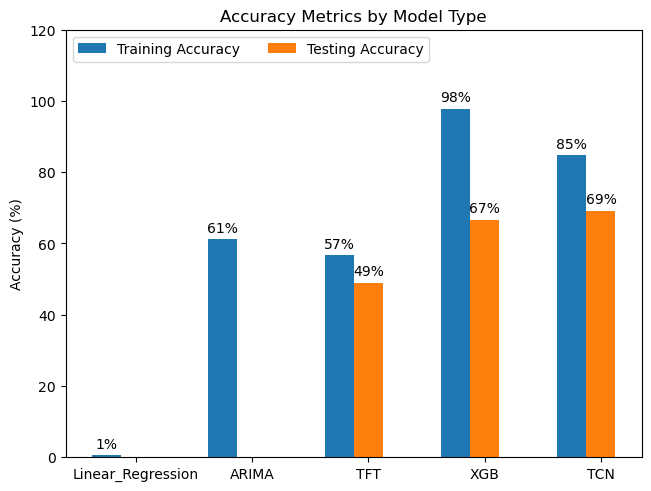

In [2]:
# Plot technique found from: 
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
# I specifically wanted the grouping visualization because it looks clean 
models = tuple(model_metrics_df.columns)

model_results = {
    'Training Accuracy':tuple(model_metrics_df.iloc[0][:]),
    'Testing Accuracy':tuple(model_metrics_df.iloc[1][:])
}

x = np.arange(len(models))
width = 0.25 
multiplier = 0 

fig,ax = plt.subplots(layout='constrained')

for acc_type, value in model_results.items():
    offset = width*multiplier
    rects = ax.bar(x+offset,value,width,label=acc_type)
    ax.bar_label(rects,fmt="%.0f%%",padding=3)
    multiplier +=1

ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Metrics by Model Type')
ax.set_xticks(x+width,models)
ax.legend(loc='upper left',ncols=5)
ax.set_ylim(0,120)

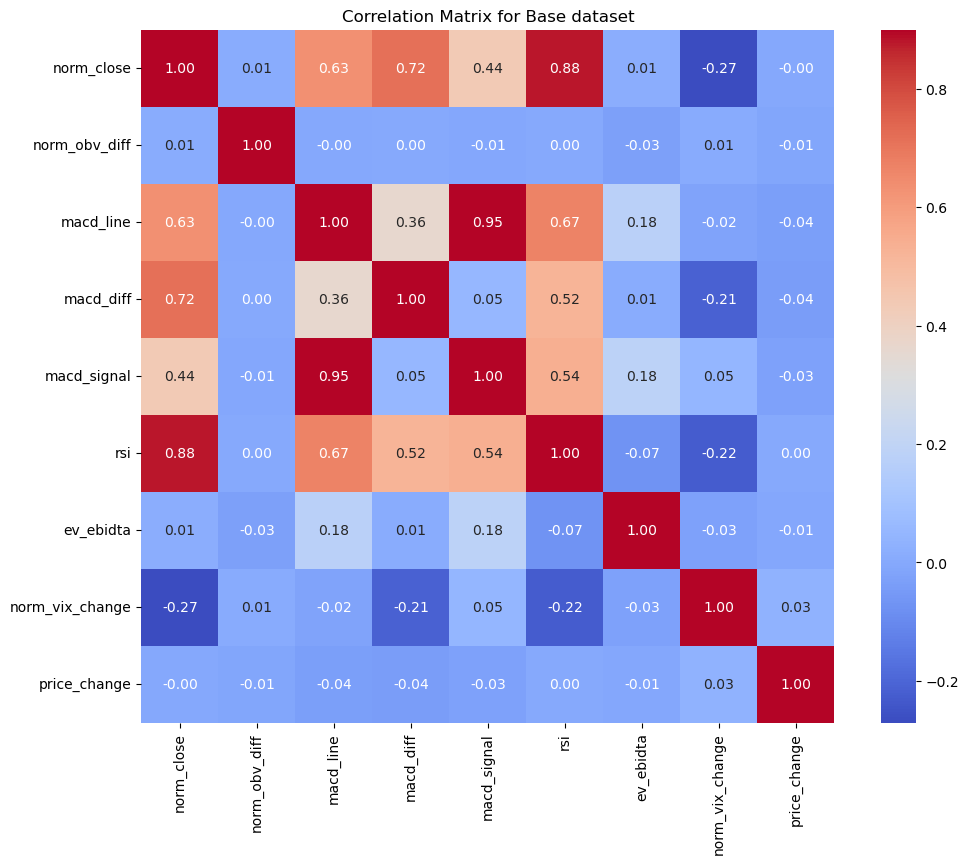

In [3]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 

data_path = '../data/'
filenames = {'Base':data_path+'aapl_model_dataset.csv',
             'ARIMA':data_path+'aapl_model_arima_dataset.csv',
             'TFT':data_path+'aapl_model_tft_dataset.csv',
             'TCN':data_path+'aapl_model_tcn_dataset.csv'}

dataset_to_plot = 'Base'

data = pd.read_csv(filenames[dataset_to_plot])
data = data.drop(['date'],axis=1)

def plot_correlation(data,title):
    # look at the correlation of columns with .corr()
    corrmat = data.corr()

    # plot the correlations with sns.heatmap
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, annot = True, fmt=".2f" , square=True, cmap='coolwarm')
    plt.title(f"Correlation Matrix for {title} dataset")

plot_correlation(data,dataset_to_plot)

# Resources

* [https://www.kaggle.com/code/yasirabdaali/make-pandas-super-fast-with-gpu-acceleration](https://www.kaggle.com/code/yasirabdaali/make-pandas-super-fast-with-gpu-acceleration)
* [https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html](https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html)
* [https://pandas.pydata.org/docs/reference/index.html](https://pandas.pydata.org/docs/reference/index.html)
* [https://medium.com/rapids-ai/arima-forecast-large-time-series-datasets-with-rapids-cuml-18428a00d02e](https://medium.com/rapids-ai/arima-forecast-large-time-series-datasets-with-rapids-cuml-18428a00d02e)
* [https://unit8co.github.io/darts/index.html](https://unit8co.github.io/darts/index.html)